Fun with comp bio coding interviews
====

William DeWitt  
UW Genome Sciences 2nd year  
Matsen/Harris labs

Overview
----

- I'll go through a few coding problems of the style one might encounter in a computational biology coding interview.

- There a few programming concepts that often come up in coding interviews.

- This isn't meant to be comprehensive, and is biased toward my experiences.

- We'll be working in Python 3! 🐍

Problem 1: DNA $\boldsymbol{k}$-mers
----
Write a function that takes an integer argument $k$ and returns all DNA sequences of length $k$.

### Case $\boldsymbol{k=2}$
We can simply loop over the possible letters (bases) in each position:

In [1]:
def twomers():
    bases = 'ACGT'
    kmer_list = []
    for base1 in bases:
        for base2 in bases:
            kmer_list.append(base1 + base2)
    return kmer_list

In [2]:
twomers()

['AA',
 'AC',
 'AG',
 'AT',
 'CA',
 'CC',
 'CG',
 'CT',
 'GA',
 'GC',
 'GG',
 'GT',
 'TA',
 'TC',
 'TG',
 'TT']

Ok cool, but:
- Can we generalize this to arbitrary $k$?
- One problem seems to be the nested loop.
- If we don't know $k$ in advance, we don't know how many nested levels of loops to code.
- Does this suggest a particular programming paradigm?

### General case
**Observation:** if we had the list of all $(k-1)$-mers, we could generate all the $k$-mers by adding each of the possible 4 bases—`A`, `C`, `G`, and `T`—to each of the $(k-1)$-mers.

**Recursion!**

In [3]:
def kmers(k:int):
    assert k > 0, 'k must be a positive integer '
    bases = 'ACGT'
    # the base case
    if k == 1:
        kmer_list = list(bases)
    # here we'll add each base to the (k - 1)-mers
    else:
        kmer_list = []
        for km1mer in kmers(k - 1):
            for base in bases:
                kmer_list.append(km1mer + base)
    return kmer_list

Does it match `twomers()` for $k=2$?

In [4]:
kmers(2) == twomers()

True

To validate for a larger $k$, say $k=10$, check that the returned list has length $4^k$:

In [5]:
len(kmers(10)) == 4**10

True

**Exercise:** Suppose you are told the call stack is limited.
Can you think of an efficient implementation that doesn't rely on recursion?

Problem 2: submatrix summation
----
Write a function that takes a rectangular array of numbers $\mathbf{A}$ and returns an array $\mathbf{B}$ of the same dimensions such that
$$B_{i j} = \sum_{k\le i}\sum_{l\le j}A_{k l}.$$
In other words, the sum of the submatrix of $\mathbf{A}$ above and to the left of position $(i,j)$, inclusive.
No `numpy` not allowed!

### Naive solution
Step through and perform sums for each element

In [6]:
from typing import List
def submatrix_sum_naive(A:List[List[float]]):
    '''assume input is a rectangular list of lists of floats'''
    # initialize to A, just to get the right shape
    B = [row.copy() for row in A]
    # loop through and compute the sum for each element
    for i in range(len(A)):
        for j in range(len(A[i])):
            B[i][j] = sum(A[k][l] for k in range(i + 1) for l in range(j + 1))
    return B

In [7]:
A = [[1, 2, 3],
     [4, 5, 6]]
submatrix_sum_naive(A)

[[1, 3, 6], [5, 12, 21]]

Ok that looks right, but:
- is this a reasonable approach if $\mathbf{A}$ is really big?
- We're repeating a lot of computations—can we avoid that?

### Less naive solution
**Observation:** The submatrix of $\mathbf{A}$ that we need to sum is pretty similar if the elements of $\mathbf{B}$ are neighbors—we just need to add a sub-row and/or or a sub-column sum to the value of the neighbor.

*whiteboard some rectangles*

**Dynamic programming!**
$$
B_{i j} = A_{i j} + B_{i-1,j} + B_{i,j-1} - B_{i-1,j-1}
$$

In [8]:
def submatrix_sum(A:List[List[float]]):
    # initialize to A, just to get the right shape
    B = [row.copy() for row in A]
    for i in range(len(A)):
        for j in range(len(A[i])):
            B[i][j] = A[i][j]
            if i > 0:
                B[i][j] += B[i - 1][j]
            if j > 0:
                B[i][j] += B[i][j - 1]
            if i > 0 and j > 0:
                B[i][j] -= B[i - 1][j - 1]
    return B

Does this match our naive implementation?

In [9]:
submatrix_sum(A) == submatrix_sum_naive(A)

True

Is it faster for a big matrix?

In [10]:
# make a 100x100 array of random numbers
from random import random
A = [[random() for _ in range(100)] for _ in range(100)]
from time import time
tic = time()
B_naive = submatrix_sum_naive(A)
toc = time()
print('naive implementation: {:.3} seconds'.format(toc - tic))
tic = time()
B_dynamic = submatrix_sum(A)
toc = time()
print('dynamic programming implementation: {:.3} seconds'.format(toc - tic))

naive implementation: 2.43 seconds
dynamic programming implementation: 0.00702 seconds


### Exercise
What if the elements of $\mathbf{B}$ are the sum of squares of the elements of the submatrix of $\mathbf{A}$?

Problem 3: half pills
----
>You have a prescription to take one half of a pill per day for 20 days but the pharmacist (who is too busy to divide pills for you) gives you 10 whole pills in a bottle.
On day 1, you remove a pill from the bottle, break it into two half pills, take one, and return the other half pill to the bottle.
On all subsequent days you shake the bottle thoroughly and pour something out whatever comes out first - either a half pill or a whole pill; if it' s a half pill you take it and you're done for that day; if it's a whole pill, you split it into two half-pills, take one, and put the other back in the bottle, exactly like you did on day 1.
On day 20 there can be only one half pill left in the bottle, but on day 19 there are two possibilities: either there is one whole pill or there are two half-pills left in the bottle.
What is the probability that there are two half-pills in the bottle on day 19?

*http://www.feynmanlectures.caltech.edu/info/exercises/half_pills.html*

### Naive solution
- We can simulate the 19 days many times and simply count the outcomes as an estimate of the probability.
- We can denote the state of the bottle with the pair of integers $(w,h)$ indicating the number of whole and half pills it contains.
- The probabilities of drawing a whole pill or half pill is $\frac{w}{w+h}$, and $\frac{h}{w+h}$, repectively.

In [11]:
def pill_sim(w:int, h:int, d:int):
    '''The bottle starts with w whole pills and h half pills and we simulate for d days'''
    for _ in range(d):
        # Bernoulli draw a whole pill or half pill
        if random() < w / (w + h):
            w -= 1
            h += 1
        else:
            h -= 1
    return (w, h)

simulation estimate: 0.763, 0.349 seconds


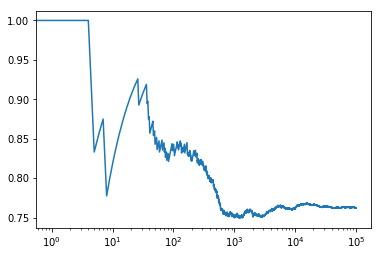

In [12]:
# count the fraction of times in 100,000 trials that the bottle has two half pills on day 19
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
trials = 100000
tic = time()
estimates = np.cumsum([int(pill_sim(10, 0, 18) == (0, 2)) for trial in range(trials)]) / np.arange(1, trials + 1)
toc = time()
print('simulation estimate: {:.3}, {:.3} seconds'.format(estimates[-1], toc - tic))
plt.plot(estimates)
plt.xscale('log')
plt.show()

Ok that seems reasonable but:
- Will this simulation approach work if the number of starting pills is very large?
- What if we pick a different state with much lower probability?
- Can we compute the probability exactly?

### Less naive solution

*whiteboard the state space*

**Observations:**
- If the bottle is in state $(w,h)$, the next draw can only bring it to neighboring states $(w - 1,h + 1)$ or $(w, h - 1)$, with probabilities $\frac{w}{w+h}$, and $\frac{h}{w+h}$, repectively.
- There's no way to cycle in the state space
- The probability of hitting a state $(w,h)$ is the sum over all paths to that state, and each path is the product of the probabilities of each step.

**Dynamic programming!**

In [13]:
from functools import lru_cache
@lru_cache(maxsize=None) # <-- this value caching is essential
def pill_prob(w, h, w0, h0):
    '''the probability of hitting state (w, h) given the bottle starts in state (w0, h0)'''
    # initial state base case
    if w == w0 and h == h0:
        return 1
    # final state base case
    elif w == 0 and h == 0:
        return 1
    # recursion
    else:
        # path 1: enter this state from the state (w + 1, h - 1) by drawing a whole pill
        if h > 0 and w < w0:
            path1_prob = ((w + 1) / (w + h)) * pill_prob(w + 1, h - 1, w0, h0)
        else:
            path1_prob = 0
        # path 2: enter this state from the state (w, h + 1) by drawing a half pill
        if h < w0:
            path2_prob = ((h + 1) / (w + h + 1)) * pill_prob(w, h + 1, w0, h0)
        else:
            path2_prob = 0
        return path1_prob + path2_prob

In [14]:
tic = time()
prob_dyn = pill_prob(0, 2, 10, 0)
toc = time()
print('dynamic programming solution: {:.3}, {:.3} seconds'.format(prob_dyn, toc - tic))

dynamic programming solution: 0.761, 0.000175 seconds


### Exercise
How can we solve this exactly with Markov chain theory?

# Thanks!

These slides can be accessed at https://wsdewitt.github.io/compbio-coding-interview